In [1]:
import json
import numpy as np
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
import os
from tqdm import tqdm
from scipy.optimize import fsolve

In [2]:
# def getTTFT(filename):
#     with open(filename, 'r') as file:
#         data = json.load(file)
#     itl=[]
#     rps=[]
#     # print(data['benchmarks'][0]['metrics'].keys())
#     for i in range(len(data['benchmarks'])):
#         # print(data['benchmarks'][i]['metrics'].keys())
#         itl.append(data['benchmarks'][i]['metrics']['time_to_first_token_ms']['successful']['mean'])
#         rps.append((data['benchmarks'][i]['metrics']['requests_per_second']['successful']['mean']))
#     itl, rps=np.array(itl), np.array(rps)
#     # print(itl)
#     # print(rps)
#     indx=np.argsort(rps)

#     return  rps[indx],itl[indx]

# def getITL(filename):
#     with open(filename, 'r') as file:
#         data = json.load(file)
#     itl=[]
#     rps=[]
#     # print(data['benchmarks'][0]['metrics'].keys())
#     for i in range(len(data['benchmarks'])):
#         # print(data['benchmarks'][i]['metrics'].keys())
#         itl.append(data['benchmarks'][i]['metrics']['inter_token_latency_ms']['successful']['mean'])
#         rps.append((data['benchmarks'][i]['metrics']['requests_per_second']['successful']['mean']))
#     itl, rps=np.array(itl), np.array(rps)
#     # print(itl)
#     # print(rps)
#     indx=np.argsort(rps)

#     return  rps[indx],itl[indx]

# def getRequestLatency(filename):
#     with open(filename, 'r') as file:
#         data = json.load(file)
#     itl=[]
#     rps=[]
#     # print(data['benchmarks'][0]['metrics'].keys())
#     for i in range(len(data['benchmarks'])):
#         # print(data['benchmarks'][i]['metrics']['request_latency']['successful'].keys())
#         itl.append(data['benchmarks'][i]['metrics']['request_latency']['successful']['mean'] * 1000)
#         rps.append((data['benchmarks'][i]['metrics']['requests_per_second']['successful']['mean']))
#     itl, rps=np.array(itl), np.array(rps)
#     # print(itl)
#     # print(rps)
#     indx=np.argsort(rps)

#     return  rps[indx],itl[indx]

# def getTPOT(filename):
#     with open(filename, 'r') as file:
#         data = json.load(file)
#     itl=[]
#     rps=[]
#     # print(data['benchmarks'][0]['metrics'].keys())
#     for i in range(len(data['benchmarks'])):
#         # print(data['benchmarks'][i]['metrics'].keys())
#         itl.append(data['benchmarks'][i]['metrics']['time_per_output_token_ms']['successful']['mean'])
#         rps.append((data['benchmarks'][i]['metrics']['requests_per_second']['successful']['mean']))
#     itl, rps=np.array(itl), np.array(rps)
#     # print(itl)
#     # print(rps)
#     indx=np.argsort(rps)

#     return  rps[indx],itl[indx]



In [3]:
def getTTFT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_to_first_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]

def getITL(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['inter_token_latency_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]

def getRequestLatency(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics']['request_latency']['successful'].keys())
        itl.append(data[i]['request_latency']['successful']['mean'] * 1000)
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]

def getTPOT(filename):
    with open(filename, 'r') as file:
        data = json.load(file)
    itl=[]
    rps=[]
    # print(data['benchmarks'][0]['metrics'].keys())
    for i in range(len(data)):
        # print(data['benchmarks'][i]['metrics'].keys())
        itl.append(data[i]['time_per_output_token_ms']['successful']['mean'])
        rps.append((data[i]['requests_per_second']['successful']['mean']))
    itl, rps=np.array(itl), np.array(rps)
    # print(itl)
    # print(rps)
    indx=np.argsort(rps)

    return  rps[indx],itl[indx]



In [4]:
def fit_ITL_from_RPS(path, label=None, debug=False):
    baseline_rps, baseline_itl = getITL(path)
    # sort the baseline_itl indices
    indx = np.argsort(baseline_itl)
    # remove the top 5 entries for both baseline_rps and baseline_itl
    # but do not change the order otherwise
    indx = indx[:-2]
    idnx = np.sort(indx)
    if debug:
        print(idnx)
    baseline_rps = baseline_rps[idnx]
    baseline_itl = baseline_itl[idnx]
    def model(x, c1, c2):
        return c1 / (1 - c2 * x)
    mask = baseline_itl != 0
    A = np.vstack([np.ones_like(baseline_rps[mask]), baseline_rps[mask]]).T
    z = 1.0 / baseline_itl[mask]
    a, b = np.linalg.lstsq(A, z, rcond=None)[0]   # z ≈ a + b x
    c1_0 = 1.0 / a
    c2_0 = -b / a
    popt, pcov = curve_fit(model, baseline_rps, baseline_itl, p0=[c1_0, c2_0], maxfev=10000)
    # plt plot the data and fit and return the fit parameters
    if debug:
        plt.scatter(baseline_rps, baseline_itl, label='Measured ITL', color='blue')
        plt.xlabel("RPS")
        plt.ylabel("ITL")
        if label is not None:
            plt.title(f"Modeled vs Measured ITL, {label}")
        else:
            plt.title("Modeled vs Measured ITL")
        plt.plot(baseline_rps, model(baseline_rps, *popt), label='Modeled ITL', color='red')
        plt.legend()

        # Add the popt parameters to the plot in the form of the formula
        plt.text(0.05, 0.95, f'ITL = {popt[0]:.2f} / (1 - {popt[1]:.2f} * RPS)', 
                transform=plt.gca().transAxes, verticalalignment='top',
                color='black')
        
        plt.show()
    return popt

In [5]:
# def saveReduced(filename, save_dir = None):
#     with open(filename, 'r') as file:
#         data = json.load(file)
#     benchmarks=[]

#     for i in range(len(data['benchmarks'])):
#         benchmarks.append(data['benchmarks'][i]['metrics'])

#     actual_filename = filename.split('/')[-1]
#     if save_dir is not None:
#         actual_filename = os.path.join(save_dir, actual_filename)
#     else:
#         actual_filename = filename
#     with open(actual_filename[:-5]+'_reduced.json', 'w') as f:
#         json.dump(benchmarks, f, indent=4)

In [6]:
# overall_dir = "/home/linghao/speculators/throughput/"
# save_dir = "/home/linghao/speculators/throughput/reduced/"
# # if save_dir does not exist, create it
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
# alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# drafts = [1, 2, 3, 4, 5, 6, 8, 10]
# model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
# for model_size in tqdm(model_sizes):
#     for alpha in alphas:
#         for draft in drafts:
#             filename = f"output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128.json"
#             saveReduced(os.path.join(overall_dir, filename), save_dir)

### Formulation: ITL = c1 / (1 - c2 * RPS)

In [7]:
model_sizes = ["0.6B", "1.7B", "4B", "8B", "14B", "32B"]
alphas = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
drafts = [1, 2, 3, 4, 5, 6, 8, 10]


In [8]:
DATA_DIR = "/home/linghao/speculators/throughput/reduced/"


In [9]:
Qwen_c1 = []
Qwen_c2 = []
for model_size in tqdm(model_sizes):

    c1 = np.empty((len(alphas), len(drafts)))
    c1[:] = np.nan
    c2 = np.empty((len(alphas), len(drafts)))
    c2[:] = np.nan

    for i, alpha in enumerate(alphas):
        for j, draft in enumerate(drafts):
            path = f"{DATA_DIR}/output_Qwen3-{model_size}_FS_alpha-{alpha:.2f}_draft-{draft}_prompt-512_output-128_concurrency-128_reduced.json"
            fit = fit_ITL_from_RPS(path, f"Alpha: {alpha}, Draft: {draft}")
            c1[i, j] = fit[0]
            c2[i, j] = fit[1]

    Qwen_c1.append(c1)
    Qwen_c2.append(c2)

100%|██████████| 6/6 [00:01<00:00,  5.69it/s]


In [10]:
# Effective sizes with tied embeddings taken into account

sizes = {0:0.76, 1:2, 2:4.4, 3:8, 4:14, 5:32}

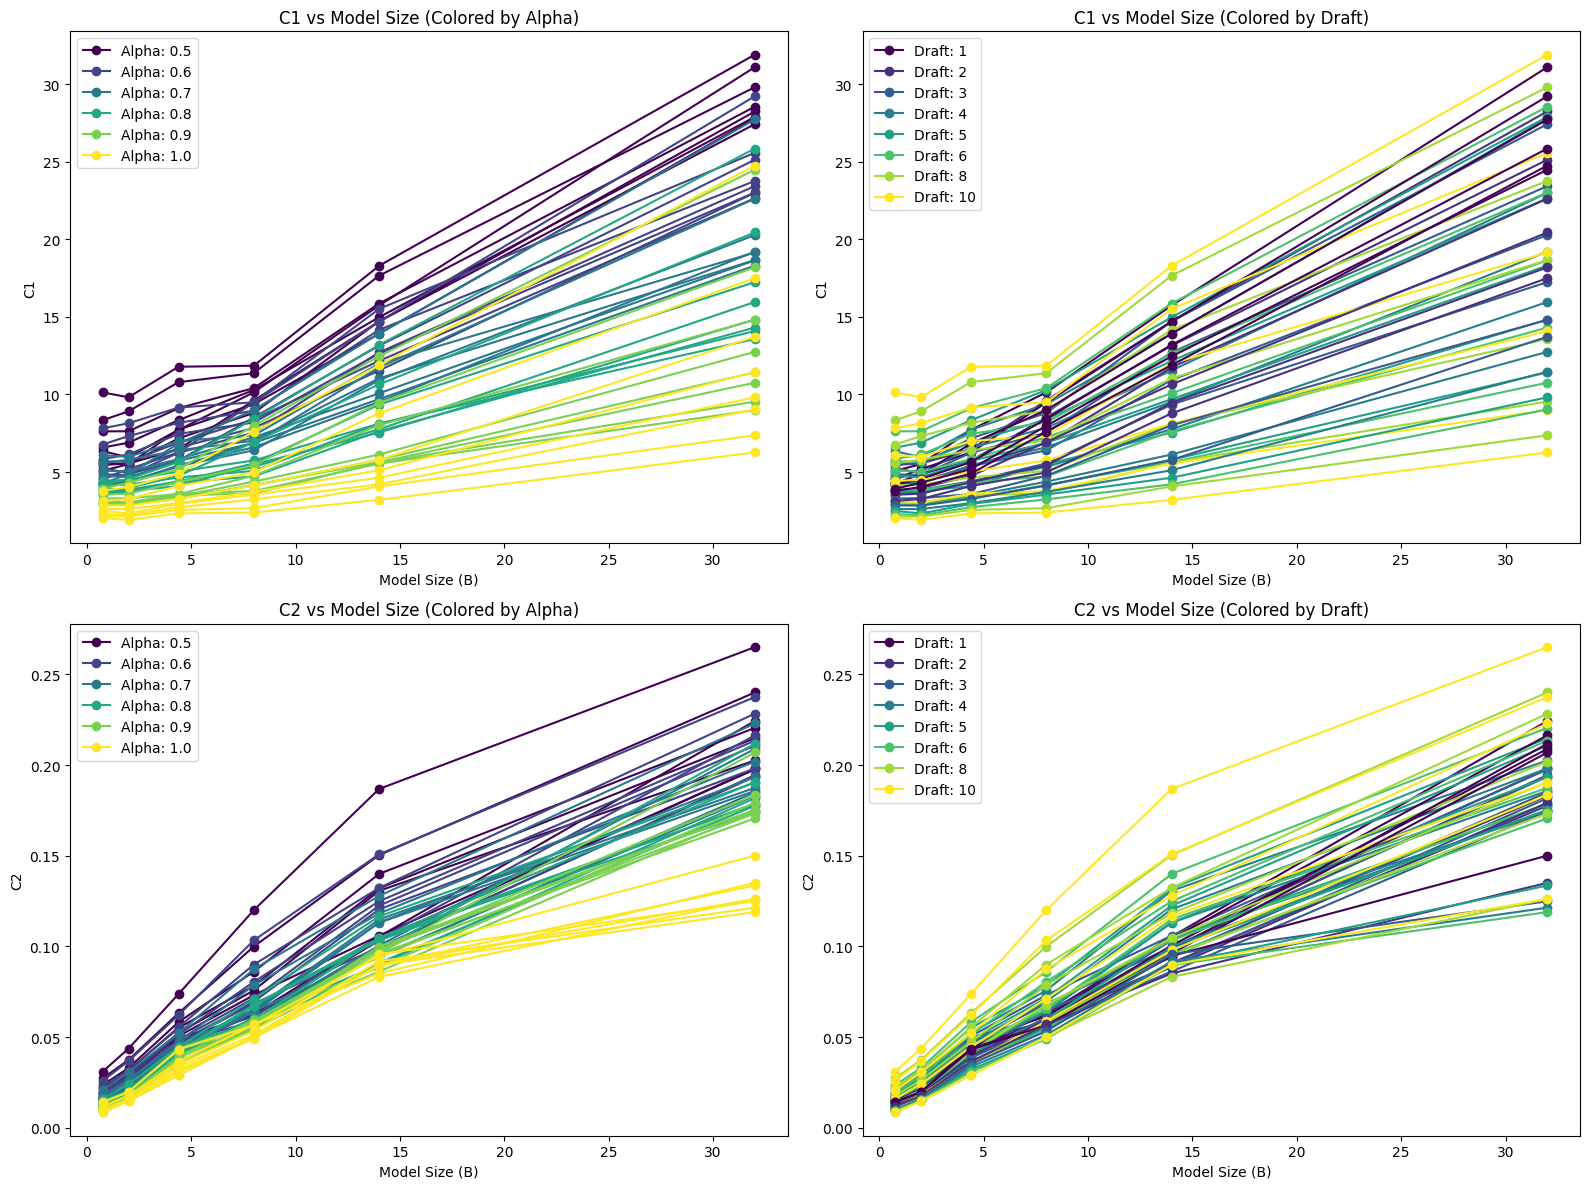

In [11]:
# Create a figure with 2x2 subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# C1 colored by alpha
alpha_colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))
for i in range(len(alphas)):
    for j in range(len(drafts)):
        x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
        y_vals = [Qwen_c1[0][i, j], Qwen_c1[1][i, j], Qwen_c1[2][i, j], Qwen_c1[3][i, j], Qwen_c1[4][i, j], Qwen_c1[5][i, j]]
        ax1.plot(x_vals, y_vals, label=f"Alpha: {alphas[i]}" if j == 0 else "", color=alpha_colors[i], marker="o")
ax1.set_xlabel("Model Size (B)")
ax1.set_ylabel("C1")
ax1.set_title("C1 vs Model Size (Colored by Alpha)")
ax1.legend()

# C1 colored by draft
draft_colors = plt.cm.viridis(np.linspace(0, 1, len(drafts)))
for i in range(len(alphas)):
    for j in range(len(drafts)):
        x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
        y_vals = [Qwen_c1[0][i, j], Qwen_c1[1][i, j], Qwen_c1[2][i, j], Qwen_c1[3][i, j], Qwen_c1[4][i, j], Qwen_c1[5][i, j]]
        ax2.plot(x_vals, y_vals, label=f"Draft: {drafts[j]}" if i == 0 else "", color=draft_colors[j], marker="o")
ax2.set_xlabel("Model Size (B)")
ax2.set_ylabel("C1")
ax2.set_title("C1 vs Model Size (Colored by Draft)")
ax2.legend()

# C2 colored by alpha
for i in range(len(alphas)):
    for j in range(len(drafts)):
        x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
        y_vals = [Qwen_c2[0][i, j], Qwen_c2[1][i, j], Qwen_c2[2][i, j], Qwen_c2[3][i, j], Qwen_c2[4][i, j], Qwen_c2[5][i, j]]
        ax3.plot(x_vals, y_vals, label=f"Alpha: {alphas[i]}" if j == 0 else "", color=alpha_colors[i], marker="o")
ax3.set_xlabel("Model Size (B)")
ax3.set_ylabel("C2")
ax3.set_title("C2 vs Model Size (Colored by Alpha)")
ax3.legend()

# C2 colored by draft
for i in range(len(alphas)):
    for j in range(len(drafts)):
        x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
        y_vals = [Qwen_c2[0][i, j], Qwen_c2[1][i, j], Qwen_c2[2][i, j], Qwen_c2[3][i, j], Qwen_c2[4][i, j], Qwen_c2[5][i, j]]
        ax4.plot(x_vals, y_vals, label=f"Draft: {drafts[j]}" if i == 0 else "", color=draft_colors[j], marker="o")
ax4.set_xlabel("Model Size (B)")
ax4.set_ylabel("C2")
ax4.set_title("C2 vs Model Size (Colored by Draft)")
ax4.legend()

plt.tight_layout()
plt.show()


In [12]:
# # Create a colormap that maps alpha values to colors
# alpha_colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

# for i in range(len(alphas)):
#     for j in range(len(drafts)):
#         x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
#         y_vals = [Qwen_c1[0][i, j], Qwen_c1[1][i, j], Qwen_c1[2][i, j], Qwen_c1[3][i, j], Qwen_c1[4][i, j], Qwen_c1[5][i, j]]
#         plt.plot(x_vals, y_vals, label=f"Alpha: {alphas[i]}" if j == 0 else "", color=alpha_colors[i], marker="o")
#     plt.legend()
# plt.xlabel("Model Size (B)")
# plt.ylabel("C1") 
# plt.title("Qwen3 Speculation: C1 vs Model Size (Colored by Alpha)")

# # plt.legend()
# plt.show()


In [13]:
# # Create a colormap that maps alpha values to colors
# draft_colors = plt.cm.viridis(np.linspace(0, 1, len(drafts)))

# for i in range(len(alphas)):
#     for j in range(len(drafts)):
#         x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
#         y_vals = [Qwen_c1[0][i, j], Qwen_c1[1][i, j], Qwen_c1[2][i, j], Qwen_c1[3][i, j], Qwen_c1[4][i, j], Qwen_c1[5][i, j]]
#         plt.plot(x_vals, y_vals, label=f"Draft: {drafts[j]}" if i == 0 else "", color=draft_colors[j], marker="o")
#     plt.legend()
# plt.xlabel("Model Size (B)")
# plt.ylabel("C1") 
# plt.title("Qwen3 Speculation: C1 vs Model Size (Colored by Draft)")

# # plt.legend()
# plt.show()


In [14]:
# # Create a colormap that maps alpha values to colors
# alpha_colors = plt.cm.viridis(np.linspace(0, 1, len(alphas)))

# for i in range(len(alphas)):
#     for j in range(len(drafts)):
#         x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
#         y_vals = [Qwen_c2[0][i, j], Qwen_c2[1][i, j], Qwen_c2[2][i, j], Qwen_c2[3][i, j], Qwen_c2[4][i, j], Qwen_c2[5][i, j]]
#         plt.plot(x_vals, y_vals, label=f"Alpha: {alphas[i]}" if j == 0 else "", color=alpha_colors[i], marker="o")
#     plt.legend()
# plt.xlabel("Model Size (B)")
# plt.ylabel("C2") 
# plt.title("Qwen3 Speculation: C2 vs Model Size (Colored by Alpha)")

# # plt.legend()
# plt.show()


In [15]:
# # Create a colormap that maps alpha values to colors
# draft_colors = plt.cm.viridis(np.linspace(0, 1, len(drafts)))

# for i in range(len(alphas)):
#     for j in range(len(drafts)):
#         x_vals = [sizes[0], sizes[1], sizes[2], sizes[3], sizes[4], sizes[5]]
#         y_vals = [Qwen_c2[0][i, j], Qwen_c2[1][i, j], Qwen_c2[2][i, j], Qwen_c2[3][i, j], Qwen_c2[4][i, j], Qwen_c2[5][i, j]]
#         plt.plot(x_vals, y_vals, label=f"Draft: {drafts[j]}" if i == 0 else "", color=draft_colors[j], marker="o")
#     plt.legend()
# plt.xlabel("Model Size (B)")
# plt.ylabel("C2") 
# plt.title("Qwen3 Speculation: C2 vs Model Size (Colored by Draft)")

# # plt.legend()
# plt.show()